In [260]:
from collections import defaultdict
from datetime import datetime
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm, exponnorm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib notebook

In [198]:
all_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/years.csv")

In [161]:
all_team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_years.csv")
all_events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/events.csv")
all_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")
all_team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_matches.csv")

C:\Users\Abhijit\AppData\Local\Temp\ipykernel_13044\2756049137.py:3: DtypeWarning: Columns (12,13,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  all_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")


In [162]:
all_matches_df = pd.merge(all_matches_df, all_events_df[["key", "week"]], left_on="event", right_on="key").rename(columns={"key_x": "key"}).drop(columns=["key_y"])

In [544]:
year = 2008

team_years_df = all_team_years_df[all_team_years_df.year == year]
matches_df = all_matches_df[(all_matches_df.year == year) & (all_matches_df.status == "Completed") & (all_matches_df.offseason == False)].sort_values(by=["time"])
team_matches_df = all_team_matches_df[(all_team_matches_df.year == year)]

In [545]:
team_matches_dict = defaultdict(dict)
for _, team_match in team_matches_df.iterrows():
    team_matches_dict[team_match.match][team_match.team] = team_match.epa

In [546]:
all_data = []
data = []

def red_accessor(match):
    if year >= 2016:
        return match.red_no_fouls
    return match.red_score

def blue_accessor(match):
    if year >= 2016:
        return match.blue_no_fouls
    return match.blue_score

for _, match in matches_df.iterrows():
    if match.status == "Upcoming" or math.isnan(red_accessor(match)):
        continue 
        
    curr_epas = team_matches_dict[match.key]
    red_epas = sorted([curr_epas[match.red_1], curr_epas[match.red_2], curr_epas[match.red_3]], reverse=True)
    blue_epas = sorted([curr_epas[match.blue_1], curr_epas[match.blue_2], curr_epas[match.blue_3]], reverse=True)
    if match.week != 8:
        data.append([red_epas, red_accessor(match)])
        data.append([blue_epas, blue_accessor(match)]) 
    all_data.append([red_epas, red_accessor(match)])
    all_data.append([blue_epas, blue_accessor(match)])

<IPython.core.display.Javascript object>


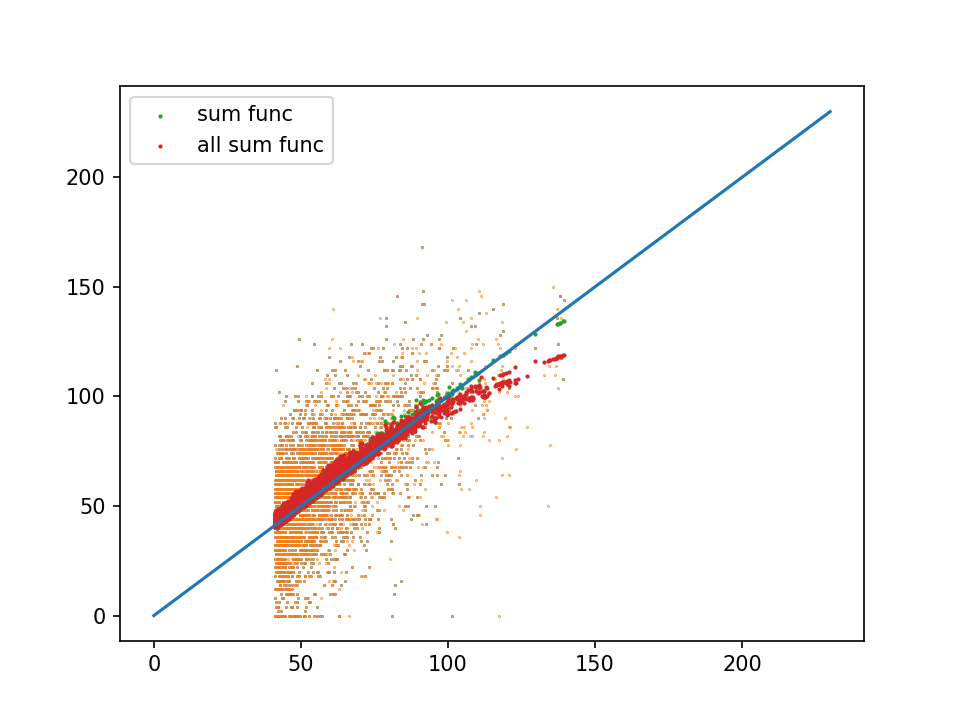

0.8473850811412925 0.554112897822267 -0.002461481482525349 1.4273907495862843 -5.184421041791895
0.8668849938064955 0.5343256193571012 -0.005169060084513784 1.682090083322292 -10.710691002361713


In [547]:
fig, ax = plt.subplots()

curr_data = all_data

score_mean = float(all_years_df[all_years_df.year == year].score_mean.iloc[0])
x = np.array([x[0] for x in data if sum(x[0]) > score_mean])
y = np.array([x[1] for x in data if sum(x[0]) > score_mean])
all_x = np.array([x[0] for x in all_data if sum(x[0]) > score_mean])
all_y = np.array([x[1] for x in all_data if sum(x[0]) > score_mean])

ax.scatter(x.sum(axis=1), y, s=0.1)
ax.scatter(all_x.sum(axis=1), all_y, s=0.1)

score_max = 3 * int(all_years_df[all_years_df.year == year].epa_max.iloc[0])
ax.plot(range(score_max), range(score_max))

def sum_func(X, a, b, c, d, e):
    (x1, x2, x3) = X
    # s = x1 + a * x2 + b * x3
    s = x1 + min(1, a) * x2 + min(1, b) * x3
    # s = x1 + x2 + x3
    # return np.minimum(s, c + (d * (s - c)))
    return c * s ** 2 + d * s + e
    # return c * s ** d + e
    
p0 = (0.5, 0.5, 0, 1, 0)

sum_popt, sum_pcov = curve_fit(sum_func, (x[:, 0], x[:, 1], x[:, 2]), y, p0)
all_sum_popt, all_sum_pcov = curve_fit(sum_func, (all_x[:, 0], all_x[:, 1], all_x[:, 2]), all_y, p0)
ax.scatter(x.sum(axis=1), sum_func((x[:, 0], x[:, 1], x[:, 2]), *sum_popt), s=1, label="sum func")
ax.scatter(all_x.sum(axis=1), sum_func((all_x[:, 0], all_x[:, 1], all_x[:, 2]), *all_sum_popt), s=1, label="all sum func")

ax.legend()
print(*sum_popt)
print(*all_sum_popt)

<IPython.core.display.Javascript object>


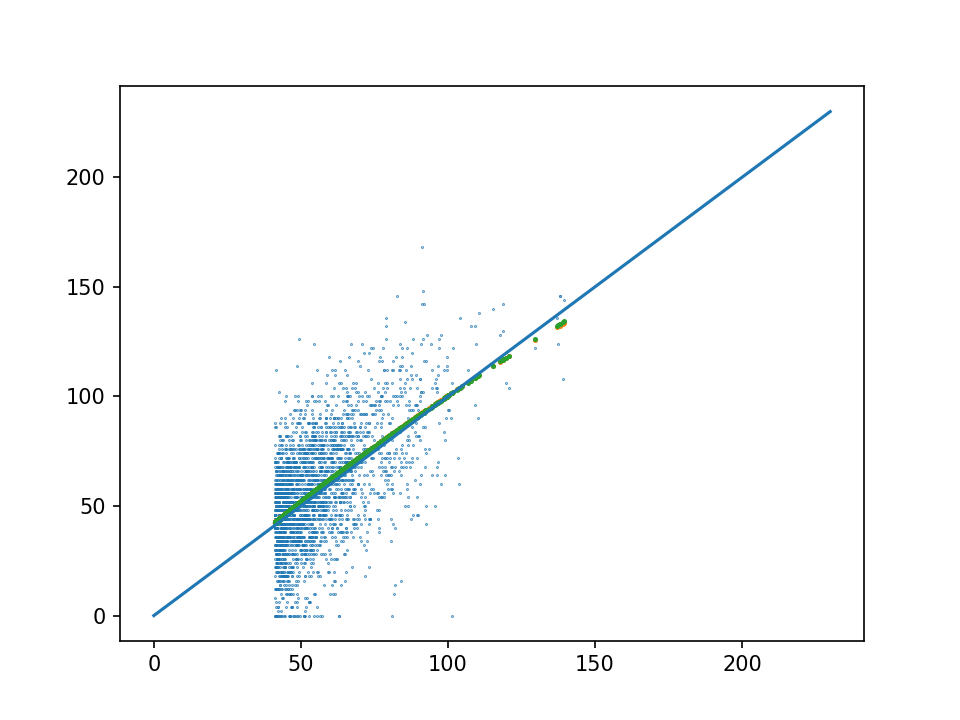

-0.0015332912839518791 1.2033617414059414 -4.503085384984642
3.5502213745323052 0.76107017650695 -17.827020204926672


In [548]:
fig, ax = plt.subplots()

score_mean = float(all_years_df[all_years_df.year == year].score_mean.iloc[0])
x = np.array([sum(x[0]) for x in data if sum(x[0]) > score_mean])
y = np.array([x[1] for x in data if sum(x[0]) > score_mean])

ax.scatter(x, y, s=0.1)

score_max = 3 * int(all_years_df[all_years_df.year == year].epa_max.iloc[0])
ax.plot(range(score_max), range(score_max))

def func(x, a, b, c):
    return a * x ** 2 + b * x + c

popt, pcov = curve_fit(func, x, y)
ax.scatter(x, func(x, *popt), s=2)

def func2(x, a, b, c):
    # return np.minimum(x, b + (c * (x - b)))
    return a * x ** b + c

popt2, pcov2 = curve_fit(func2, x, y, maxfev=20000)
ax.scatter(x, func2(x, *popt2), s=2)

print(*popt)
print(*popt2)

In [549]:
class TeamYear:
    def __init__(self, init):
        self.count = 0
        self.total = [init]
        
    def add_match(self, count, total):
        self.count += count
        self.total.append(total)

In [550]:
class ModelStats:
    def __init__(self):
        self.win_prob = []
        
    def record_stats(self, match, red_pred, blue_pred, win_prob):
        winner = {"blue": 0, "red": 1, "draw": 0.5}[match.winner]
        common = {"week": match.week, "event": match.event, "playoff": match.playoff, "key": match.key}
        
        self.win_prob.append({
            **common, 
            "winner": match.winner, 
            "win_prob": win_prob, 
            "conf": max(win_prob, 1 - win_prob), 
            "acc": (win_prob > 0.5) == winner, 
            "mse": (winner - win_prob) ** 2,
        })
            
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean"})
            rounded = [f"{temp.conf:.4f}", f"{temp.acc:.4f}", f"{temp.mse:.4f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE")
        agg_win_prob("Season", lambda x: x[(x.week < 8)])
        agg_win_prob("Champs", lambda x: x[(x.week == 8)])
        agg_win_prob("Quals", lambda x: x[(x.playoff == False)])
        agg_win_prob("Elims", lambda x: x[(x.playoff == True)])
        agg_win_prob("Champs Elims", lambda x: x[(x.week == 8) & (x.playoff == True)])
        agg_win_prob("Total", lambda x: x)
        print()

In [551]:
starting_epas = {x.team: x.epa_start for _, x in team_years_df.iterrows()}

# print(starting_epas[5511])

In [552]:
def margin_func(x):
    return min(1, max(0, 1 / 24 * (x - 12)))


def percent_func(x):
    return min(0.5, max(0.3, 0.5 - 0.2 / 6 * (x - 6)))


MEAN = all_years_df[all_years_df.year == year].score_mean.iloc[0]
SD = all_years_df[all_years_df.year == year].score_sd.iloc[0]


def process_season(use_correction):
    team_years = {}
    model_stats = ModelStats()
    champs_count, champs_abs, champs_mse = 0, 0, 0
    for _, t in team_years_df.iterrows():
        team = t.team
        prior = MEAN / 3
        if team in starting_epas:
            prior = starting_epas[team]
            
        team_years[team] = TeamYear(prior)

    for _, match in matches_df.iterrows():
        red_teams = [int(match.red_1), int(match.red_2), int(match.red_3)]
        blue_teams = [int(match.blue_1), int(match.blue_2), int(match.blue_3)]

        red_pred = sum([team_years[t].total[-1] for t in red_teams])
        blue_pred = sum([team_years[t].total[-1] for t in blue_teams])
        
        if use_correction and red_pred > score_mean:
            red_pred = sorted([team_years[t].total[-1] for t in red_teams], reverse=True)
            red_pred = sum_func(red_pred, *sum_popt)
        
        if use_correction and blue_pred > score_mean:
            blue_pred = sorted([team_years[t].total[-1] for t in blue_teams], reverse=True)
            blue_pred = sum_func(blue_pred, *sum_popt)
            # red_pred = func(red_pred, *popt)
            # blue_pred = func(blue_pred, *popt)
            
        if match.week == 8 and match.playoff:
            print(match.key, red_pred, blue_pred, red_accessor(match), blue_accessor(match))
            champs_abs += (red_pred - red_accessor(match))
            champs_abs += (blue_pred - blue_accessor(match))
            champs_mse += (red_pred - red_accessor(match)) ** 2
            champs_mse += (blue_pred - blue_accessor(match)) ** 2
            champs_count += 2
        
        win_prob = 1 / (1 + 10 ** (-5/8 * (red_pred - blue_pred) / SD))
        
        model_stats.record_stats(match, red_pred, blue_pred, win_prob)
        
        weight = 1 / 3 if match.playoff else 1

        red_score = red_accessor(match)
        blue_score = blue_accessor(match)
        for teams, my_score, opp_score, my_pred, opp_pred in [
            (red_teams, red_score, blue_score, red_pred, blue_pred),
            (blue_teams, blue_score, red_score, blue_pred, red_pred),
        ]:
            for team in teams:
                team_year = team_years[team]
                percent, margin_factor = percent_func(team_year.count), margin_func(team_year.count)
                error = ((my_score - my_pred) + margin_factor * (opp_pred - opp_score)) / (1 + margin_factor)
                total = team_year.total[-1] + percent * weight * error / 3
                team_year.add_match(0 if match.playoff else 1, total)
    
    model_stats.print_stats()
    if champs_count > 0:
        print(champs_abs / champs_count)
        print(champs_mse / champs_count)
    return team_years

print("No Correction")
team_years = process_season(False)
print()

print("Correction")
team_years_with_correction = process_season(True)

No Correction
2008cur_qf1m1 112.88647459909178 76.81774569874213 98 46
2008arc_qf1m1 87.84063118104194 77.13227443554017 114 88
2008new_qf1m1 118.51351545094823 78.10632034639852 122 52
2008gal_qf1m1 137.64211687522982 69.74821966021142 110 76
2008arc_qf1m2 89.18029581150199 77.76845272171175 122 68
2008cur_qf1m2 113.07632131152411 74.69508432329536 80 60
2008gal_qf1m2 135.8381045051063 71.07692551160387 78 48
2008new_qf1m2 119.71867660714726 76.20498855513198 108 54
2008arc_qf2m1 103.96636395745278 78.01335958014538 96 90
2008cur_qf2m1 115.77258481372459 81.04606738564348 96 72
2008new_qf2m1 104.80934819476524 99.76560180527889 102 112
2008gal_qf2m1 126.84320199724223 85.10351370986406 122 70
2008gal_qf2m2 126.94378549118504 84.30534237337034 76 50
2008cur_qf2m2 114.75594807233105 81.06620177877362 124 88
2008new_qf2m2 104.1865374506815 100.69713867480243 112 100
2008arc_qf2m2 102.9969412116213 79.13974098919246 118 68
2008new_qf2m3 104.70975246976673 100.40702534718451 112 102
2008ne

<IPython.core.display.Javascript object>


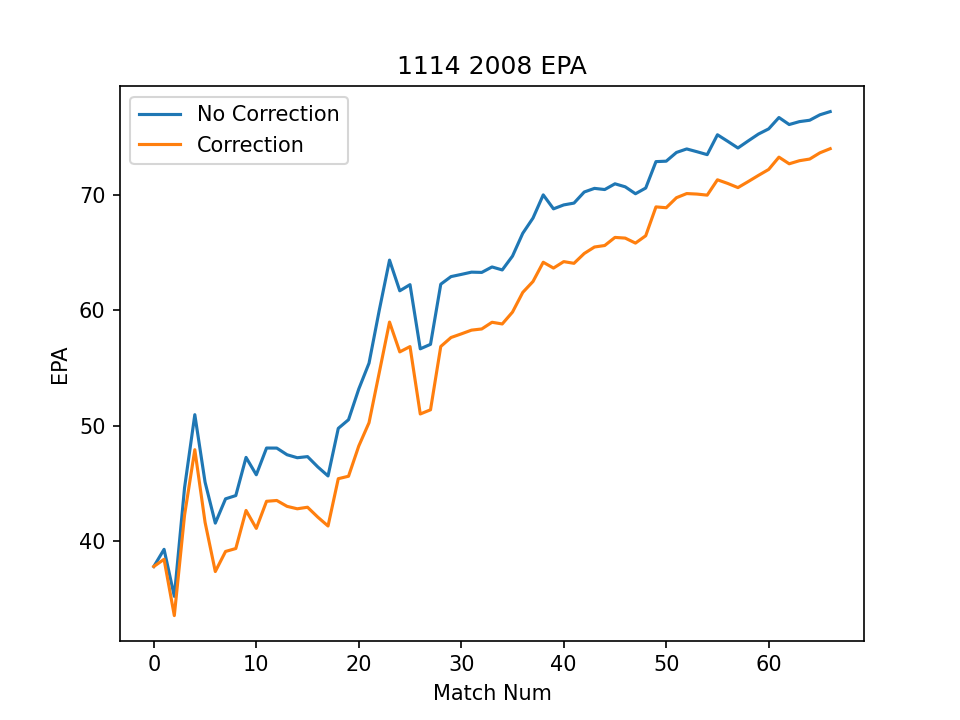

In [553]:
fig, ax = plt.subplots()

team = 1114

team_ratings = team_years[team].total
team_ratings_with_priors = team_years_with_correction[team].total
N = len(team_ratings)

ax.plot(range(N), team_ratings, label="No Correction")
ax.plot(range(N), team_ratings_with_priors, label="Correction")

ax.legend()
ax.set_xlabel("Match Num")
ax.set_ylabel("EPA")
ax.set_title(str(team) + " " + str(year) + " EPA")
fig.show()

In [554]:
end_team_ratings = {k: v.total[-1] for (k, v) in team_years.items() if not math.isnan(v.total[-1])}
print(sorted(end_team_ratings.items(), key=lambda x: -x[1])[:8])

end_team_ratings_with_correction = {k: v.total[-1] for (k, v) in team_years_with_correction.items() if not math.isnan(v.total[-1])}
print(sorted(end_team_ratings_with_correction.items(), key=lambda x: -x[1])[:8])

for x in sorted(end_team_ratings.items(), key=lambda x: -x[1])[:25]:
    print(x[0], "\t", round(x[1], 4), "\t", round(end_team_ratings_with_correction[x[0]], 4))

[(1114, 77.18465629636975), (987, 53.93427358389689), (67, 52.44248935493597), (2056, 52.351069028231116), (525, 49.77550222336692), (39, 49.56695406569096), (968, 48.796694599831234), (103, 47.6117390016557)]
[(1114, 73.97453992755855), (67, 51.18606930883373), (2056, 50.12739061508995), (987, 49.860967143897945), (968, 48.19407295687615), (525, 47.20577789691694), (39, 46.49290622612066), (103, 45.67543129166825)]
1114 	 77.1847 	 73.9745
987 	 53.9343 	 49.861
67 	 52.4425 	 51.1861
2056 	 52.3511 	 50.1274
525 	 49.7755 	 47.2058
39 	 49.567 	 46.4929
968 	 48.7967 	 48.1941
103 	 47.6117 	 45.6754
1024 	 46.0637 	 43.4973
233 	 44.809 	 41.6215
330 	 44.6887 	 42.3232
1126 	 43.8541 	 43.101
1731 	 43.7255 	 41.2272
71 	 43.4039 	 42.3774
217 	 42.1821 	 41.2601
25 	 41.7192 	 38.9511
254 	 41.2876 	 40.484
100 	 41.2331 	 40.0094
141 	 39.522 	 38.7006
1717 	 38.7885 	 36.8532
111 	 38.7161 	 37.6384
1124 	 37.9426 	 39.1371
20 	 37.6238 	 35.4321
1251 	 37.5777 	 35.9648
1625 	 